In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import spotipy
from spotipy.oauth2 import SpotifyOAuth
import json
import keys

In [10]:
def get_data():
    songs = pd.read_csv('data/big_df_audio_features.csv')
    songs.set_index(['name','artist'], inplace = True)
    return songs

In [4]:
def scale_data(data):
    minmax = MinMaxScaler(feature_range=(0,1))
    songs_scaled_minmax = minmax.fit_transform(data)
    songs_scaled_minmax = pd.DataFrame(songs_scaled_minmax, columns = data.columns, index = data.index)
    return songs_scaled_minmax

In [8]:
def get_evolution_graph(data):
    max_k = 20
    min_k = 10
    inertia = []

    for k in range(min_k, max_k): 
        inertia.append(KMeans(n_clusters=k).fit(data).inertia_)

    fig, ax = plt.subplots(figsize=(12, 6))
    plt.title(f'Inertia evolution from 1 cluster to {max_k} cluster')
    sns.lineplot(x=range(min_k, max_k), y=inertia)
    sns.scatterplot(x=range(min_k, max_k), y=inertia)
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()

In [14]:
def get_silhouette_score_graph(data):
    max_k = 20
    min_k = 5
    sil_score = []

    for k in range(min_k, max_k): 
        labels = KMeans(n_clusters=k).fit(data).labels_
        sil_score.append(silhouette_score(data, labels))

    plt.title(f'Silhouette score evolution from 2 cluster to {max_k} clusters')
    sns.lineplot(x=range(min_k, max_k), y=sil_score)
    sns.scatterplot(x=range(min_k, max_k), y=sil_score)
    plt.show()

In [29]:
scaled_data = scale_data(get_data())

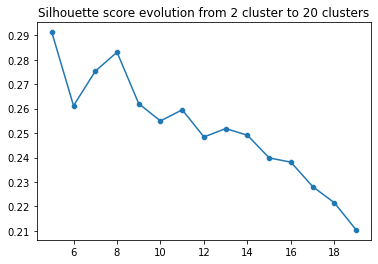

In [25]:
get_silhouette_score_graph(scaled_data)

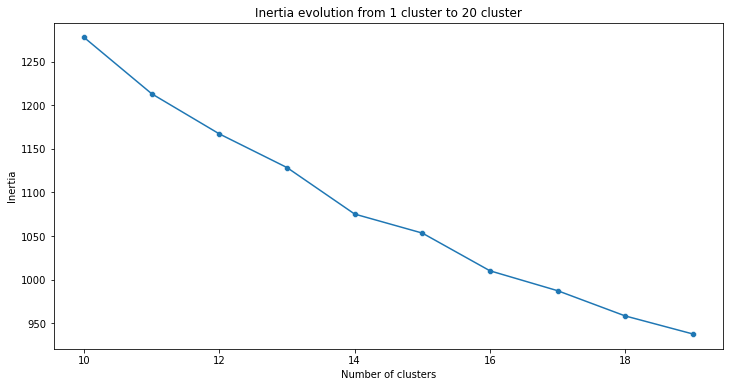

In [26]:
get_evolution_graph(scaled_data)

In [30]:
songs_kmeans = KMeans(n_clusters=13)
songs_kmeans.fit(scaled_data)
cluster_centers_df = pd.DataFrame(data=songs_kmeans.cluster_centers_, columns= scaled_data.columns)
scaled_data['cluster'] = songs_kmeans.labels_

In [32]:
list_of_playlists= []
for i in range(12):
    list_of_playlists.append(scaled_data.query('cluster == @i'))
    list_of_playlists[i] = list_of_playlists[i].assign(distance=0)
    for j, song in list_of_playlists[i].iterrows():
        total = sum(((song.iloc[pos]- cluster_centers_df.iloc[1][pos])**2) for pos in range(scaled_data.shape[1]-3))**(1/2)
        list_of_playlists[i].loc[j,'distance'] = total
    list_of_playlists[i] = list_of_playlists[i].sort_values('distance').head(50)
    list_of_playlists[i] = list_of_playlists[i].reset_index()

C:\Users\HANA\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2894: PerformanceWarning: indexing past lexsort depth may impact performance.
  result = self._run_cell(
C:\Users\HANA\anaconda3\lib\site-packages\IPython\core\async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


In [35]:
scope = 'playlist-modify-public'
username = keys.username
redirectUri = 'http://localhost:8888/callback'

token = SpotifyOAuth(scope=scope,username=username,client_id=keys.client_id, client_secret=keys.client_secret ,redirect_uri='http://localhost:7000/callback')
spotifyObject = spotipy.Spotify(auth_manager = token)

In [37]:
for i, playlist in enumerate(list_of_playlists):
    playlist_name = f'Playlist_cluster_{i}'
    playlist_description= ''
    playlist_id = spotifyObject.user_playlist_create(user=username,name=playlist_name,public=True,description=playlist_description)['id']
    list_of_songs = []
    for index, song in playlist.iterrows():
        result = spotifyObject.search(q=f"{song['name']} artist:{song['artist']}",type='track',limit=1)
        try:
            list_of_songs.append(result['tracks']['items'][0]['uri'])
        except:
            continue
    spotifyObject.user_playlist_add_tracks(user=username,playlist_id=playlist_id,tracks=list_of_songs)